# Movie Recommend by Surprise with GridSearch

In this notebook, optimize hyperparameters of Surprise using GridSearchCV.

In [1]:
import sys
import random
from surprise import Dataset, Reader
from surprise import KNNBasic, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.dataset import DatasetAutoFolds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import operator
import requests
from zipfile import ZipFile

In [17]:
df = pd.read_csv('/kaggle/input/movies-and-ratings-for-recommendation-system/ratings.csv', 
                          error_bad_lines=False, 
                          warn_bad_lines=False,
                          skiprows=lambda i: i>0 and random.random() > 0.1)
df.columns=['user_id','item_id','rating','timestamp']
print(len(df))

10043


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['user_id','item_id','rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


    # cross_validate

    # Run 5-fold cross-validation and print results.
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    print(results)

# GridSearchCV - algo to best_algo

In [4]:
algo = KNNBasic

param_grid = { 'k': [5,10,15,20,50], 'min_k': [2,3,4,5] }
gs = GridSearchCV(algo, param_grid, cv=5)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [5]:
print(gs.best_params)
best_algo = KNNBasic(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'])
print(best_algo.k, best_algo.min_k)

{'rmse': {'k': 15, 'min_k': 5}, 'mae': {'k': 15, 'min_k': 5}}
15 5


In [6]:
help(best_algo)

Help on KNNBasic in module surprise.prediction_algorithms.knns object:

class KNNBasic(SymmetricAlgo)
 |  KNNBasic(k=40, min_k=1, sim_options={'user_based': True}, verbose=True, **kwargs)
 |  
 |  A basic collaborative filtering algorithm.
 |  
 |  The prediction :math:`\hat{r}_{ui}` is set as:
 |  
 |  .. math::
 |      \hat{r}_{ui} = \frac{
 |      \sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}
 |      {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)}
 |  
 |  or
 |  
 |  .. math::
 |      \hat{r}_{ui} = \frac{
 |      \sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}
 |      {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)}
 |  
 |  depending on the ``user_based`` field of the ``sim_options`` parameter.
 |  
 |  Args:
 |      k(int): The (max) number of neighbors to take into account for
 |          aggregation (see :ref:`this note <actual_k_note>`). Default is
 |          ``40``.
 |      min_k(int): The minimum number of neighbors to take into account for
 |     

# best_algo - fit & test

In [7]:
trainset, testset = train_test_split(data, test_size=0.25)

best_algo.fit(trainset)

predictions = best_algo.test(testset)
print(predictions[0:2])

Computing the msd similarity matrix...
Done computing similarity matrix.
[Prediction(uid=292, iid=1291, r_ui=4.5, est=3.5127262828365318, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}), Prediction(uid=182, iid=3326, r_ui=2.5, est=3.5127262828365318, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})]


In [8]:
import itertools

for uid, iid, rating in itertools.islice(trainset.all_ratings(), 5):
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")
    
print()    
print(trainset.n_ratings,len(testset))

User 0 rated item 0 with a rating of 5.0
User 0 rated item 213 with a rating of 3.0
User 0 rated item 801 with a rating of 4.0
User 0 rated item 1018 with a rating of 3.0
User 0 rated item 1414 with a rating of 4.0

User 292 rated item 1291 with a rating of 4.5
User 182 rated item 3326 with a rating of 2.5
User 89 rated item 56367 with a rating of 2.0
User 200 rated item 5617 with a rating of 3.5
User 232 rated item 37720 with a rating of 3.0

7347 2450


In [9]:
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User 292 rated item 1291 with a rating of 4.5
User 182 rated item 3326 with a rating of 2.5
User 89 rated item 56367 with a rating of 2.0
User 200 rated item 5617 with a rating of 3.5
User 232 rated item 37720 with a rating of 3.0


The 'predictions' is a list of tuples of the form (user, item, actual_rating, predicted_rating, details). The predicted_rating is est value.

In [10]:
for prediction in predictions[0:5]:
    print(prediction)

user: 292        item: 1291       r_ui = 4.50   est = 3.51   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 182        item: 3326       r_ui = 2.50   est = 3.51   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 89         item: 56367      r_ui = 2.00   est = 3.51   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 200        item: 5617       r_ui = 3.50   est = 3.51   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 232        item: 37720      r_ui = 3.00   est = 3.51   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [11]:
# Print the performance metrics
accuracy.rmse(predictions)

RMSE: 1.0626


1.0626366532296367

In [12]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

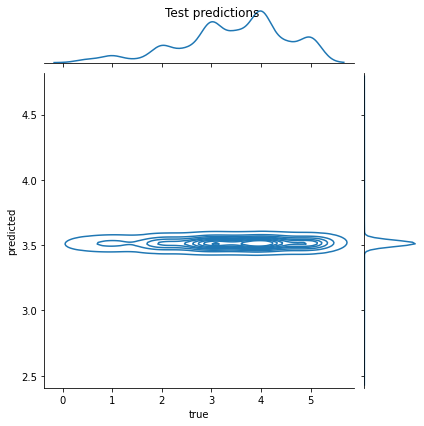

In [13]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

# Recommend unseen books for test set users

In [14]:
import pandas as pd
books=pd.read_csv('/kaggle/input/movies-and-ratings-for-recommendation-system/movies.csv')
#display(movies)
mapping = books.set_index("movieId")["title"].to_dict()
#print(mapping)

In [15]:
users=list(set(uids))

In [16]:
# items which the user not yet evaluate
items = trainset.build_anti_testset()
for user in users[0:30]:
    user_items = list(filter(lambda x: x[0] == user, items))
    # generate recommendation
    recommendations = best_algo.test(user_items)
    if len(recommendations)>0:
        recommendations.sort(key=operator.itemgetter(3), reverse=True)
        print(f"For User {user}:")
        for r in recommendations[0:5]:
            try:
                print(f"  {mapping[r[1]]} : [{round(r[3],3)}]")
            except:
                continue

For User 1:
  American Beauty (1999) : [4.442]
  Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : [4.286]
  Silence of the Lambs, The (1991) : [4.276]
  Ghostbusters (a.k.a. Ghost Busters) (1984) : [4.26]
  Shawshank Redemption, The (1994) : [4.247]
For User 2:
  Space Jam (1996) : [3.513]
  Mrs. Doubtfire (1993) : [3.513]
  Brazil (1985) : [3.513]
  Braveheart (1995) : [3.513]
  Ravenous (1999) : [3.513]
For User 3:
  Space Jam (1996) : [3.513]
  Mrs. Doubtfire (1993) : [3.513]
  Brazil (1985) : [3.513]
  Braveheart (1995) : [3.513]
  Ravenous (1999) : [3.513]
For User 4:
  Star Wars: Episode V - The Empire Strikes Back (1980) : [4.738]
  Alien (1979) : [4.337]
  Lord of the Rings: The Two Towers, The (2002) : [4.311]
  Bourne Identity, The (2002) : [4.22]
  Lord of the Rings: The Return of the King, The (2003) : [4.215]
For User 6:
  Fugitive, The (1993) : [4.184]
  Batman (1989) : [3.79]
  Space Jam (1996) : [3.513]
  Mrs. Doubtfire (1993) : [3.513]
 